In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
from scipy.optimize import fsolve
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from cebefo_style import Set_2D_colz_graphics
from particle import Particle

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel

from matplotlib import pyplot as plt

Welcome to JupyROOT 6.10/08


In [2]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

In [3]:
from uproot_methods.classes import TLorentzVector as urTLV

In [4]:
tmu = ur.open('../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates.root')['outA']['Tevts']
print tmu.keys(), '\n\n'
branches = [b for b in tmu.keys() if b[:2] == 'MC']
for b in np.sort(branches):
    print b
    
dmu = {}
for b in branches:
    dmu[b] = tmu.array(b)

['LumiBlock', 'MC_B_P', 'MC_B_eta', 'MC_B_phi', 'MC_B_pt', 'MC_D0_P', 'MC_D0_eta', 'MC_D0_phi', 'MC_D0_pt', 'MC_Dst_P', 'MC_Dst_eta', 'MC_Dst_phi', 'MC_Dst_pt', 'MC_Est_mu', 'MC_M2_miss', 'MC_mu_P', 'MC_mu_eta', 'MC_mu_phi', 'MC_mu_pt', 'MC_pis_P', 'MC_pis_eta', 'MC_pis_phi', 'MC_pis_pt', 'MC_q2', 'Run', 'eventNumber', 'n_B', 'n_D0', 'n_Dst', 'n_K', 'n_pi', 'n_pis', 'trgMu_charge', 'trgMu_eta', 'trgMu_phi', 'trgMu_pt', 'B_E', 'B_P', 'B_eta', 'B_phi', 'B_pt', 'B_pz', 'D0_E', 'D0_P', 'D0_eta', 'D0_phi', 'D0_pt', 'D0_pz', 'Dst_E', 'Dst_P', 'Dst_eta', 'Dst_phi', 'Dst_pt', 'Dst_pz', 'Est_mu', 'K_E', 'K_P', 'K_eta', 'K_phi', 'K_pt', 'K_pz', 'M2_miss', 'chi2_D0pis', 'chi2_MuDst', 'chi2_kpi', 'cos_D0pis_vtxMu', 'cos_MuDst_vtxMu', 'cos_kpi_vtxMu', 'd_vtxD0pis_vtxMu', 'd_vtxkpi_vtxMu', 'dca_D0pis_vtxMu', 'dca_kpi_vtxMu', 'mass_D0pis', 'mass_MuDst', 'mass_kpi', 'mu_E', 'mu_P', 'mu_eta', 'mu_phi', 'mu_pt', 'mu_pz', 'pi_E', 'pi_P', 'pi_eta', 'pi_phi', 'pi_pt', 'pi_pz', 'pis_E', 'pis_P', 'pis_eta', 

In [25]:
def create_urTLV(d, k, m):
    px = d[k+'_pt'] * np.cos(d[k+'_phi'])
    py = d[k+'_pt'] * np.sin(d[k+'_phi'])
    pz = d[k+'_pt'] * np.sinh(d[k+'_eta']).astype(np.float64)
    
    e = np.sqrt(m**2 + np.square(d[k+'_P']))
    return urTLV.TLorentzVectorArray(px, py, pz, e)

In [26]:
PB = create_urTLV(dmu, 'MC_B', 1e-3*Particle.from_string('B0').mass)
Pmu = create_urTLV(dmu, 'MC_mu', 1e-3*Particle.from_string('mu').mass)
PDst = create_urTLV(dmu, 'MC_Dst', 1e-3*Particle.from_string('D*-').mass)

Pv = Pmu + PDst

1.122912006046306e-06 5.9167549216153396e-05


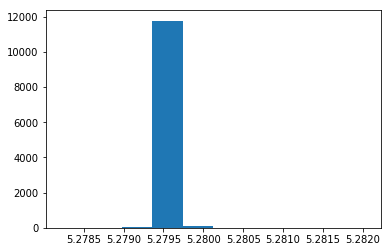

In [27]:
plt.hist(PB.mass)
print np.mean(PB.mass)-1e-3*Particle.from_string('B0').mass, np.std(PB.mass)

Now get the B momentum form different approximations

## MC truth

In [28]:
MCtruth = {}
MCtruth['B_pz'] = PB.z
MCtruth['B_p3'] = PB.p3

MCtruth['PB'] = PB

MCtruth['M2_miss'] = dmu['MC_M2_miss']
MCtruth['q2'] = dmu['MC_q2']

## Longitudinal Approx (a-la-LHCb)

In [29]:
LongApp = {}
LongApp['B_pz'] = Pv.z * 1e-3*Particle.from_string('B0').mass / Pv.mass
LongApp['B_p3'] = PB.p3 * LongApp['B_pz'] / PB.p3.z

e = np.sqrt(LongApp['B_p3'].mag2 + (1e-3*Particle.from_string('B0').mass)**2)
LongApp['PB'] = urTLV.TLorentzVectorArray(LongApp['B_p3'].x, LongApp['B_p3'].y, LongApp['B_p3'].z, e)

LongApp['M2_miss'] = (LongApp['PB'] - Pv).mass2
LongApp['q2'] = (LongApp['PB'] - PDst).mass2

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


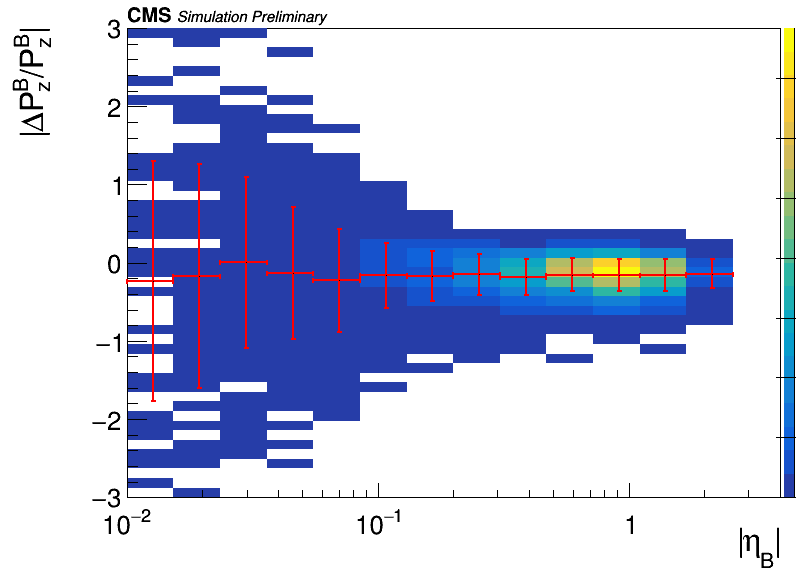

In [30]:
h = create_TH2D(
            np.column_stack((np.abs(PB.eta), (PB.z-LongApp['B_pz'])/PB.z)),
            binning = [np.logspace(-2, np.log10(4), 15), np.linspace(-3, 3, 50)],
            axis_title = ['|#eta_{B}|', '|#DeltaP_{z}^{B}/P_{z}^{B}|', '']
           )

hpfy = h.ProfileX('hpfy', 1, -1, 's')
hpfy.SetLineColor(2)
c = drawOnCMSCanvas(CMS_lumi, [h, hpfy], ['colz', 'sameE1'])
c.SetLogx()

## Transverse Approx

In [31]:
TranApp = {}
TranApp['B_pt'] = Pv.pt * 1e-3*Particle.from_string('B0').mass / Pv.mass
TranApp['B_p3'] = PB.p3 * TranApp['B_pt'] / PB.pt
TranApp['B_pz'] = TranApp['B_p3'].z

e = np.sqrt(TranApp['B_p3'].mag2 + (1e-3*Particle.from_string('B0').mass)**2)
TranApp['PB'] = urTLV.TLorentzVectorArray(TranApp['B_p3'].x, TranApp['B_p3'].y, TranApp['B_p3'].z, e)

TranApp['M2_miss'] = (TranApp['PB'] - Pv).mass2
TranApp['q2'] = (TranApp['PB'] - PDst).mass2

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


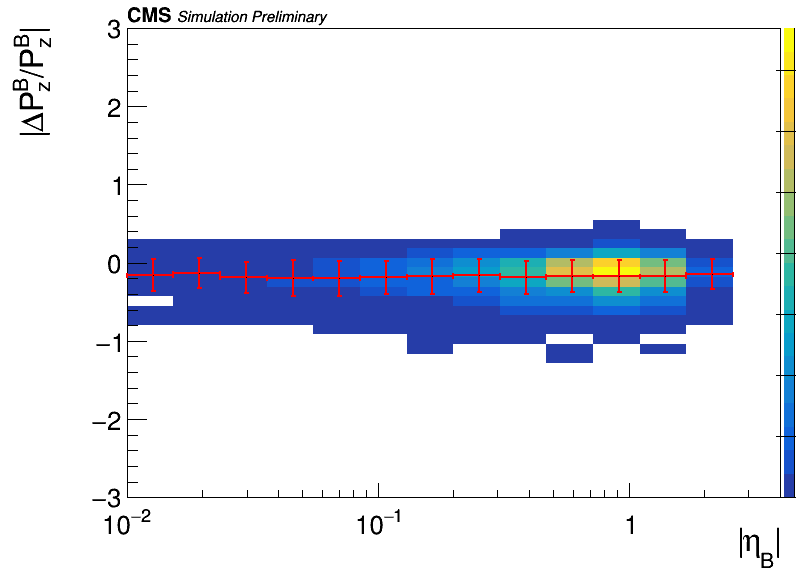

In [32]:
h = create_TH2D(
            np.column_stack((np.abs(PB.eta), (PB.z-TranApp['B_pz'])/PB.z)),
            binning = [np.logspace(-2, np.log10(4), 15), np.linspace(-3, 3, 50)],
            axis_title = ['|#eta_{B}|', '|#DeltaP_{z}^{B}/P_{z}^{B}|', '']
           )

hpfy = h.ProfileX('hpfy', 1, -1, 's')
hpfy.SetLineColor(2)
c = drawOnCMSCanvas(CMS_lumi, [h, hpfy], ['colz', 'sameE1'])
c.SetLogx()

## BoostBCM

In [33]:
def equations(x, *a):
    g, pzst, ptst = x
    nz, nt, e, pz, pt, mv = a
    
    gb = np.sqrt(g*g-1)
    
    eq1 = g*e - gb*nz*pz - gb*nt*pt
    eq1 -= np.sqrt(mv*mv + pzst*pzst + ptst*ptst)
    
    eq2 = -gb*nz*e 
    eq2 += pz*( 1. + (g-1)*nz*nz )
    eq2 += pt*(g-1)*nz*nt
    eq2 -= pzst
    
    eq3 = -gb*nt*e
    eq3 += pz*(g-1)*nz*nt
    eq3 += pt*( 1. + (g-1)*nt*nt )
    eq3 -= ptst
    
    return (eq1, eq2, eq3)

### Test

Get the arguments

In [35]:
for i_evt in range(5):
    print '------- Event', i_evt, '--------'
    nz = PB.z[i_evt]/PB.p[i_evt]
    nt = PB.pt[i_evt]/PB.p[i_evt]
    e = Pv.E[i_evt]
    pz = Pv.z[i_evt]
    pt = Pv.pt[i_evt]
    mv = Pv.mass[i_evt]
    
    # Get the starting estimation from transverse approx
    g_init = TranApp['PB'].gamma[i_evt]
    P_vis_lv = rt.TLorentzVector()
    P_vis_lv.SetPxPyPzE(Pv.x[i_evt], Pv.y[i_evt], pz, e)
    P_vis_lv.Boost(-TranApp['PB'].boostp3[i_evt].x, -TranApp['PB'].boostp3[i_evt].y, -TranApp['PB'].boostp3[i_evt].z)
    
    pzst_init = P_vis_lv.Px()
    ptst_init = P_vis_lv.Pt()
    
    print 'Initial status'
    print 'Init: {:.2f} {:.2f} {:.2f}'.format(g_init, pzst_init, ptst_init)
    r1, r2, r3 =  equations((g_init, pzst_init, ptst_init), nz, nt, e, pz, pt, mv)
    print 'Loss val: {:.2f} {:.2f} {:.2f}'.format(r1, r2, r3)
    print
    
    # Mimization step
    out = fsolve(
               equations, 
               x0=(g_init, pzst_init, ptst_init), 
               args = (nz, nt, e, pz, pt, mv)
              )
    g_opt, pzst_opt, ptst_opt = out
    print 'Final status'
    print 'Init: {:.2f} {:.2f} {:.2f}'.format(g_opt, pzst_opt, ptst_opt)
    r1, r2, r3 =  equations((g_opt, pzst_opt, ptst_opt), nz, nt, e, pz, pt, mv)
    print 'Loss val: {:.2f} {:.2f} {:.2f}'.format(r1, r2, r3)
    print
    
    # Get the exact solution
    g_true = PB.gamma[i_evt]

    P_vis_lv = rt.TLorentzVector()
    P_vis_lv.SetPxPyPzE(Pv.x[i_evt], Pv.y[i_evt], pz, e)
    P_vis_lv.Boost(-PB.boostp3[i_evt].x, -PB.boostp3[i_evt].y, -PB.boostp3[i_evt].z)
    
    pzst_true = P_vis_lv.Px()
    ptst_true = P_vis_lv.Pt()

    print 'True status'
    print 'Init: {:.2f} {:.2f} {:.2f}'.format(g_true, pzst_true, ptst_true)
    r1, r2, r3 =  equations((g_true, pzst_true, ptst_true), nz, nt, e, pz, pt, mv)
    print 'Loss val: {:.2f} {:.2f} {:.2f}'.format(r1, r2, r3)
    print '\n'

------- Event 0 --------
Initial status
Init: 4.72 0.45 0.48
Loss val: 0.01 0.25 -0.48

Final status
Init: 4.41 0.67 0.30
Loss val: -0.00 0.00 0.00

True status
Init: 4.20 0.62 0.69
Loss val: -0.02 0.02 -0.17


------- Event 1 --------
Initial status
Init: 9.54 0.23 1.30
Loss val: -0.23 -0.18 -1.26

Final status
Init: 6.95 -0.76 0.94
Loss val: -0.00 -0.00 0.00

True status
Init: 8.27 -0.19 1.32
Loss val: -0.19 -0.12 -0.88


------- Event 2 --------
Initial status
Init: 17.36 -0.34 0.64
Loss val: 0.27 -1.13 -0.15

Final status
Init: 13.16 -0.91 1.33
Loss val: 0.00 0.00 -0.00

True status
Init: 13.56 -1.06 1.29
Loss val: -0.04 0.08 -0.06


------- Event 3 --------
Initial status
Init: 7.84 -0.44 0.54
Loss val: -0.06 0.28 -0.49

Final status
Init: 6.82 0.03 0.51
Loss val: -0.00 0.00 0.00

True status
Init: 5.33 -1.24 1.43
Loss val: -0.21 1.60 -0.08


------- Event 4 --------
Initial status
Init: 9.94 -0.71 0.76
Loss val: 0.08 -0.32 -1.47

Final status
Init: 7.11 -1.51 0.29
Loss val: -0.00

### For all events

In [36]:
gamma = []
for i_evt in range(PB.z.shape[0]):
    nz = PB.z[i_evt]/PB.p[i_evt]
    nt = PB.pt[i_evt]/PB.p[i_evt]
    e = Pv.E[i_evt]
    pz = Pv.z[i_evt]
    pt = Pv.pt[i_evt]
    mv = Pv.mass[i_evt]
    
    # Get the starting estimation from transverse approx
    g_init = TranApp['PB'].gamma[i_evt]
    P_vis_lv = rt.TLorentzVector()
    P_vis_lv.SetPxPyPzE(Pv.x[i_evt], Pv.y[i_evt], pz, e)
    P_vis_lv.Boost(-TranApp['PB'].boostp3[i_evt].x, -TranApp['PB'].boostp3[i_evt].y, -TranApp['PB'].boostp3[i_evt].z)
    
    pzst_init = P_vis_lv.Px()
    ptst_init = P_vis_lv.Pt()
    
    # Mimization step
    out = fsolve(
               equations, 
               x0=(g_init, pzst_init, ptst_init), 
               args = (nz, nt, e, pz, pt, mv)
              )
    g_opt, pzst_opt, ptst_opt = out
    gamma.append(g_opt)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [45]:
gamma = np.array(gamma)

BoostBCM = {}

BoostBCM['gamma'] = gamma
BoostBCM['B_P'] = np.sqrt(np.square(gamma) - 1) * 1e-3*Particle.from_string('B0').mass

BoostBCM['B_p3'] = PB.p3 * BoostBCM['B_P'] / PB.p
BoostBCM['B_pt'] = np.hypot(BoostBCM['B_p3'].x, BoostBCM['B_p3'].y)
BoostBCM['B_pz'] = BoostBCM['B_p3'].z

e = np.sqrt(BoostBCM['B_p3'].mag2 + (1e-3*Particle.from_string('B0').mass)**2)
BoostBCM['PB'] = urTLV.TLorentzVectorArray(BoostBCM['B_p3'].x, BoostBCM['B_p3'].y, BoostBCM['B_p3'].z, e)

BoostBCM['M2_miss'] = (BoostBCM['PB'] - Pv).mass2
BoostBCM['q2'] = (BoostBCM['PB'] - PDst).mass2

# Variable comparison

In [46]:
dic_list = {'MC Truth': MCtruth,
            'Long. approx': LongApp,
            'Trans. approx': TranApp,
            'Boost B cm': BoostBCM
           }

In [47]:
def draw_var(vname, xtitle, binning, opt, leg_loc):
    h_l = []

    leg = rt.TLegend(leg_loc[0],leg_loc[1],leg_loc[2],leg_loc[3])
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    for n, d in dic_list.iteritems():
        h_aux = create_TH1D(
            d[vname], 
            axis_title=[xtitle, 'Events'], 
            binning=binning, opt=opt
        )
        h_aux.SetLineColor(std_color_list[len(h_l)])
        h_aux.Sumw2()
        leg.AddEntry(h_aux, n, 'l')
        h_l.append(h_aux)
    SetMaxToMaxHist(h_l)


    CMS_lumi.extraText = "     Simulation Preliminary"
    c = drawOnCMSCanvas(CMS_lumi, h_l, 'same')
    c.h_l = h_l
    c.leg = leg
    leg.Draw()
    return c

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


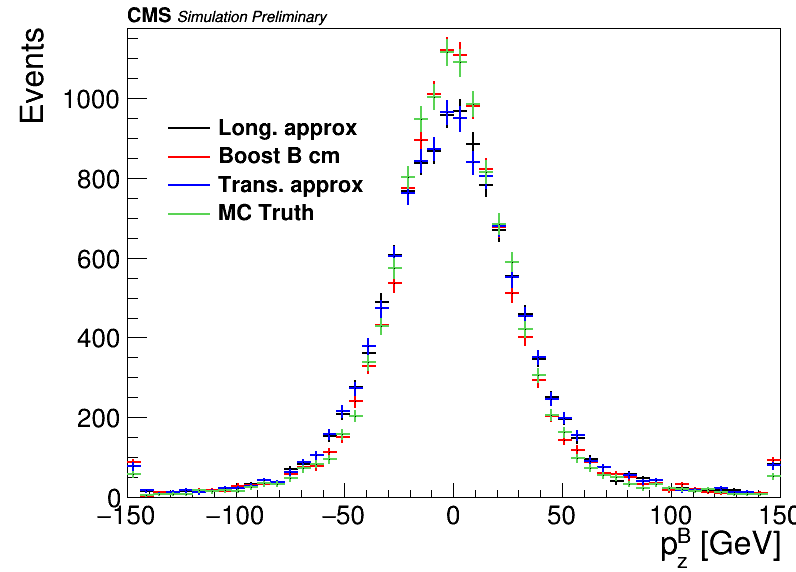

In [48]:
c = draw_var('B_pz', 'p_{z}^{B} [GeV]', binning=[50, -150, 150], opt='underflowoverflow', leg_loc=[0.2,0.6,0.5,0.8])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


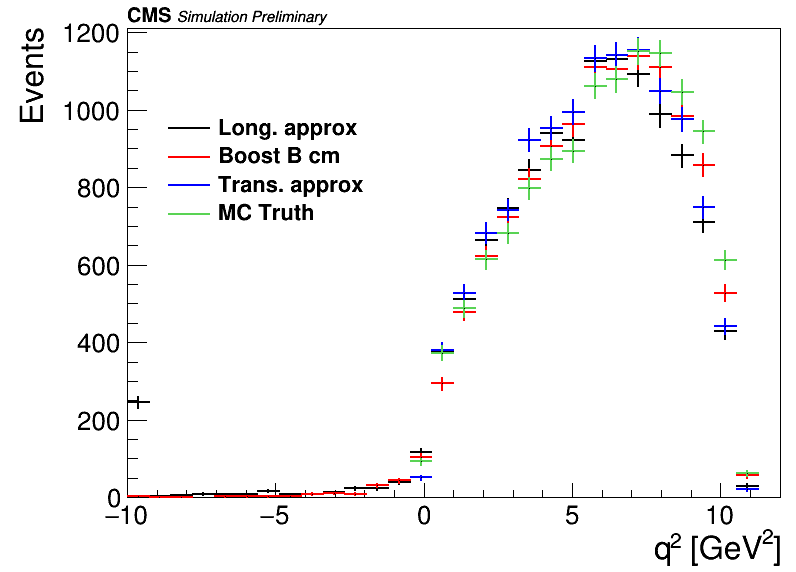

In [49]:
c = draw_var('q2', 'q^{2} [GeV^{2}]', binning=[30, -10, 12], opt='underflow', leg_loc=[0.2,0.6,0.5,0.8])

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


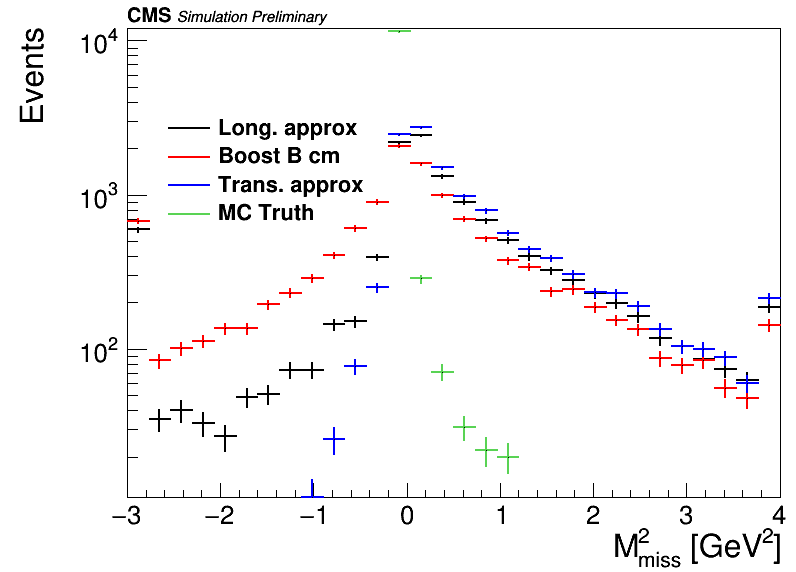

In [50]:
c = draw_var('M2_miss', 'M^{2}_{miss} [GeV^{2}]', binning=[30, -3, 4], opt='underflowoverflow', leg_loc=[0.2,0.6,0.5,0.8])
c.SetLogy()